# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, your are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from tensorflow import keras as ks

import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incompleteGOGOKB/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimnesion 64x64

In [4]:
sequences = sequences/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 20, 64, 64, 1)
0.0 1.0


Let us split the dataset in training, validation and testing.
You are supposed to evaluate the performance of your model using MSE over the full test set.

In [5]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[9000:10000]

Here is a simple generator, creating the input sequences of 3 frames, and the expected output, namely the next frame.

In [6]:
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,seqlen-1,64,64,1))
      batch_y = np.zeros((batchsize,1,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      minibatch = dataset[ran]
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i] = minibatch[i,random_start:random_end,:,:]
          batch_y[i] = minibatch[i,random_end:random_end+1,:,:]
          #print(batch_x.shape,batch_y.shape)
          #print(batch_x.min(),batch_x.max())
          #print(batch_x.min(),batch_x.max())
      yield(batch_x,batch_y)


In [7]:
prova_gen = image_generator(testset,batchsize=1,seqlen=4)

In [8]:
sample_x, sample_y = next(prova_gen)

In [9]:
print(sample_x.shape)
print(sample_y.shape)

(1, 3, 64, 64, 1)
(1, 1, 64, 64, 1)


In [10]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray',)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

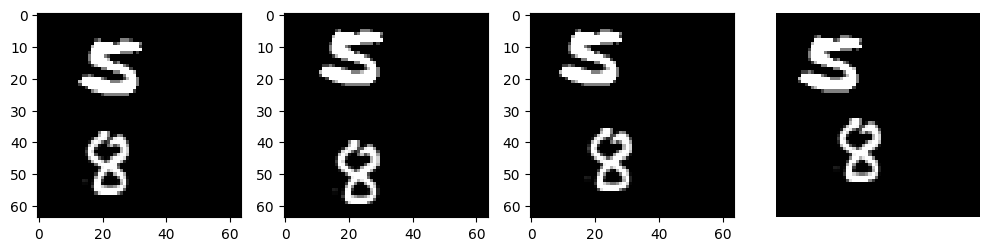

In [11]:
all = [sample_x[0,i,:,:,:] for i in range(3)]+[sample_y[0,0,:,:,:]]
show_list(all)

In [12]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(testset)

In [13]:
sample_x, sample_y = next(train_gen)

I've used the `display_MSE` function to show the trend of Mean Squared Error during training after fitting the model. The graph will show both the training set trend and the validation one.


In [14]:
def display_MSE(history):

    mse_training = history.history['loss']
    mse_val = history.history['val_loss']

    # Visualize the behavior of the MSE
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('MSE during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

##Model


Reasoning about the task given, some ideas initially emerged based on the topics covered in class and during lab sessions correlated with my own experience.
At first glance what I found interesting to direct my attention were mainly three approaches:
- Transformers
- U-net
- LSTM and GRU (RNN)<br>

At first I began to implement transformers, considering some relevant papers in the field such as: [Anticipative Video Transformer](https://arxiv.org/abs/2106.02036) and [Latent Video Transformer](https://arxiv.org/abs/2006.10704) which, however works better with large datasets and they are not the most indicated for this specific task. <br>

Secondly I directed my attention to the implementation of some variations of U-net, but they don’t reach such a good results. <br>

I focused my efforts on utilizing Recurrent Neural Networks (RNNs) for frame prediction, as they are better suited for this task compared to transformers, especially when working with smaller datasets and assuming no pre-training.

To enhance the performance of the RNNs, I experimented with combining layers such as GRUs, LSTMs, Pooling, Normalization, and Convolution. During this process, I came across a model in the Keras documentation (https://keras.io/examples/vision/conv_lstm/) that caught my attention. It leverages Convolutional LSTMs, which combine time series processing and computer vision by introducing a convolutional recurrent cell within an LSTM layer.

One challenge I encountered was dealing with the input and output sizes. The ConvLSTM2D layer operates with shape 5, so I deleted the "sneeze" from the code above maintaining the last channel dimension since the images are grayscale.

Regarding the output, initially, the model was generating 3 frames because it matched the shape of the input. However, upon analyzing the output frames, I found that the third frame was the most accurate. To address this, I incorporated a lambda function and reshaped the output to only capture the last frame.

Before the reshape, I included a Convolutional 3D layer to handle the spatiotemporal outputs effectively. Additionally, I decided to insert LeakyReLU activation functions with an alpha value of 0.60 after each convLSTM2D. However, I kept the final activation function (into the Conv3D) as sigmoid to ensure the return value falls within the range of 0 to 1.

To prevent overfitting I have setted the parameter 'recurrent dropout' of the convLSTM2Ds equal to 0.15 which is the fraction of the units to drop for the linear transformation of the recurrent state.

I used the mean squared error (MSE) as the chosen error metric to minimize, as requested. Additionally, I employed accuracy as a metric to assess the model's level of precision.

Important is the choice of the optimizer, after some trials I have chosen Nadam which is Adam with Nesterov momentum.

In [38]:
# Construct the input layer.
inp = layers.Input(shape=(3, 64, 64,1))

# I will construct 4 `ConvLSTM2D` layers with batch normalization, followed by a `Conv3D` layer for the spatiotemporal outputs.
x1 = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(11, 11),
    padding="same",
    return_sequences=True,
    recurrent_dropout=0.15,

)(inp)
x2 = layers.LeakyReLU(alpha=0.60)(x1)
x3 = layers.BatchNormalization()(x2)
x4 = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    recurrent_dropout=0.15,

)(x3)
x5 = layers.LeakyReLU(alpha=0.60)(x4)
x6 = layers.BatchNormalization()(x5)
x7 = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    recurrent_dropout=0.15,

)(x6)
x8 = layers.LeakyReLU(alpha=0.60)(x7)
x9 = layers.BatchNormalization()(x8)
x10 = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    recurrent_dropout=0.15,

)(x9)
x11 = layers.LeakyReLU(alpha=0.60)(x10)
x12 = layers.Conv3D(
    filters=1, kernel_size=(1, 3, 3),
    activation="sigmoid",
    padding="same"
)(x11)

#Keep the third frame (last one) as output
separate_layers = []
separate_layer = layers.Lambda(lambda x: x[:,-1,:,:,:])(x12)
separate_layer = layers.Reshape((1,64,64,1))(separate_layer)
separate_layers.append(separate_layer)

# Next, I will build the complete model and compile it.
model = keras.models.Model(inp, separate_layers)
model.compile(
    loss=keras.losses.MeanSquaredError(), metrics=['accuracy'], optimizer=tf.keras.optimizers.Nadam())
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 64, 64, 1)]    0         
                                                                 
 conv_lstm2d_12 (ConvLSTM2D)  (None, 3, 64, 64, 64)    2013696   
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 3, 64, 64, 64)     0         
                                                                 
 batch_normalization_9 (Batc  (None, 3, 64, 64, 64)    256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, 3, 64, 64, 64)    1605888   
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 3, 64, 64, 64)     0         
                                                           

##Model Training

For training the model, I opted to run it for 30 epochs due to the ongoing decrease in mean squared error (MSE) throughout the training process. Additionally, I set the batch size to 16.

In the `fit` function, I passed the `train_gen` as the first argument, which contains both the training samples and labels. Similarly, for the validation data, I used `val_gen`. The total number of learned samples per epoch can be calculated as follows:

$n=$ `steps_per_epoch` × `batchsize`

To determine the `steps_per_epoch`, I set it equal to the integer division of the length of the training set by the batch size: `steps_per_epoch = len(trainset)//batchsize` (resulting in ( $n = 500 \times 16 = 8000 $)). I maintained the `validation_steps` value as `len(valset)//batchsize` to ensure that the computation was not overly time-consuming.

To prevent overfitting, I incorporated the `early_stopping` callback, which halts training if there is no improvement in `val_loss` after 5 epochs. This allows for early termination of the training process.

In [39]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 30
batch_size = 16

# Fit the model to the training data.
history = model.fit(
    x=train_gen, batch_size= batch_size, steps_per_epoch = len(trainset)//batch_size, validation_data= val_gen, validation_steps= len(valset)//batch_size, epochs = epochs, verbose=1, callbacks= early_stopping)


Epoch 1/30
500/500 [==============================] - 442s 855ms/step - loss: 0.0190 - accuracy: 0.9237 - val_loss: 0.0240 - val_accuracy: 0.9293
Epoch 2/30
500/500 [==============================] - 426s 851ms/step - loss: 0.0135 - accuracy: 0.9266 - val_loss: 0.0128 - val_accuracy: 0.9269
Epoch 3/30
500/500 [==============================] - 425s 851ms/step - loss: 0.0124 - accuracy: 0.9271 - val_loss: 0.0125 - val_accuracy: 0.9254
Epoch 4/30
500/500 [==============================] - 425s 850ms/step - loss: 0.0118 - accuracy: 0.9274 - val_loss: 0.0119 - val_accuracy: 0.9272
Epoch 5/30
500/500 [==============================] - 425s 850ms/step - loss: 0.0114 - accuracy: 0.9277 - val_loss: 0.0114 - val_accuracy: 0.9267
Epoch 6/30
500/500 [==============================] - 424s 849ms/step - loss: 0.0109 - accuracy: 0.9281 - val_loss: 0.0110 - val_accuracy: 0.9266
Epoch 7/30
500/500 [==============================] - 424s 847ms/step - loss: 0.0108 - accuracy: 0.9285 - val_loss: 0.0105 -

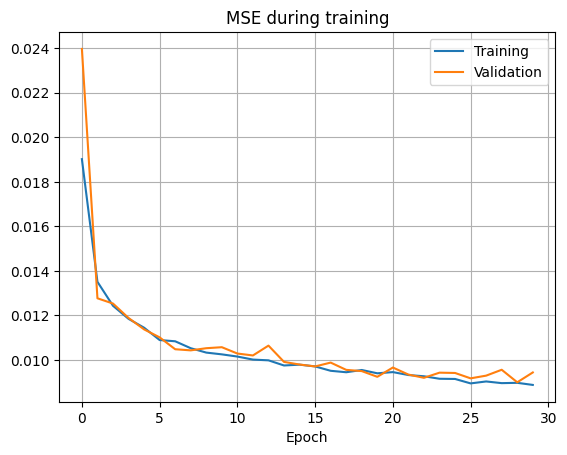

In [40]:
display_MSE(history)

The graph depicted above illustrates the decrease in mean squared error (MSE) for both the training and validation sets during the training process. Initially, the MSE decreases rapidly in the early epochs, and subsequently, the rate of change becomes smaller until it reaches a value of 0.0089 after 30 epochs. Importantly, the graph indicates that the model does not overfit, as the training loss closely aligns with the validation loss.

Additionally, the MSE computed on the validation set is considerably low, suggesting that the model is likely to perform well when evaluated on the test set. This anticipation is based on the observed small MSE value during the validation phase.

1/1 [==============================] - 0s 29ms/step
(1, 1, 64, 64, 1)


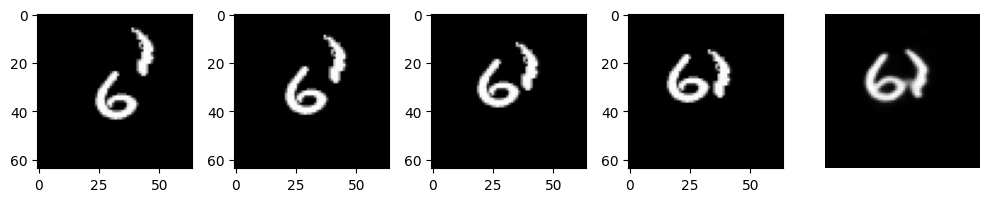

In [42]:
from sklearn import metrics

prova_gen = image_generator(testset, batchsize=1, seqlen=4)

sample_x, sample_y = next(prova_gen)
new_prediction = model.predict(sample_x)
print(new_prediction.shape)

all_out = [sample_x[0,i,:,:,:] for i in range(3)]+[sample_y[0,0,:,:,0]] + [new_prediction[0,0,:,:,0]]

show_list(all_out)



Above, we can visually evaluate the performance of the model. In this example, the first three frames serve as input to the model, while the fourth frame is the expected output, and the last is the generated output from the model. The model appears to perform well, as the disparity between the last two frames is minimal. This observation is supported by the mean squared error calculated from these last two frames, which demonstrates a small value.

In [43]:
print(metrics.mean_squared_error(sample_y[0,0,:,:,0], new_prediction[0,0,:,:,0]))

0.003613870276110392


I used the model.evaluate method to calculate the mean squared error for the entire test set, which consists of 1000 samples. The resulting MSE value is 0.00895, which serves as my definitive score.

In [50]:
model.evaluate(x=test_gen, steps = len(testset)//batch_size, verbose=1)

62/62 [==============================] - 12s 184ms/step - loss: 0.0090 - accuracy: 0.9299


[0.008955705910921097, 0.9298619627952576]

I also conducted evaluations on each element of the test set in another way. I iterated over batches of test data and appended the inputs (x), true outputs (y), and predicted outputs to separate lists. The Mean Squared Error (MSE) is calculated between each true output and predicted output, accumulating the MSE values in mse_tot. Finally, the average MSE, mse_final, is obtained by dividing mse_tot by the length of the test set. As anticipated, the manually calculated mean squared error closely aligns with the automated result mentioned earlier.

In [47]:
test_x = []
test_y = []
predicted = []
for i in range(1000//batch_size):
  x,y = next(test_gen)
  test_x = test_x + [*x]
  test_y = test_y + [*y]
  predicted = predicted + [*model.predict(x)[:,-1]]
mse = tf.keras.losses.MeanSquaredError()
mse_tot = 0
for i in range(len(test_y)):
  mse_tot += mse(test_y[i], predicted[i]).numpy()
mse_final = mse_tot / len(test_y)

1/1 [==============================] - 0s 31ms/step


In [31]:
print(mse_final)

0.008996890635546973
